# Training biophysical models

In this tutorial, you will learn how to train biophysical models in `Jaxley`. This includes the following:

- compute the gradient with respect to parameters  
- use parameter transformations  
- use multi-level checkpointing  
- define optimizers  
- write dataloaders and parallelize across data  

Here is a code snippet which you will learn to understand in this tutorial:
```python
from jax import jit, vmap, value_and_grad
import jaxley as jx
import jaxley.optimize.transforms as jt

net = ...  # See tutorial on the basics of `Jaxley`.

# Define which parameters to train.
net.cell("all").make_trainable("HH_gNa")
net.IonotropicSynapse.make_trainable("IonotropicSynapse_gS")
parameters = net.get_parameters()

# Define parameter transform and apply it to the parameters.
transform = jx.ParamTransform([
    {"HH_gNa": jt.SigmoidTransform(0.0, 1.0)},
    {"IonotropicSynapse_gS": jt.SigmoidTransform(0.0, 1.0)},
])

opt_params = transform.inverse(parameters)

# Define simulation and batch it across stimuli.
def simulate(params, datapoint):
    # Define stimuli.
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=datapoint, delta_t=0.025, t_max=5.0)
    data_stimuli = None
    data_stimuli = net.cell(0).branch(0).comp(0).data_stimulate(currents[0], data_stimuli)
    data_stimuli = net.cell(1).branch(0).comp(0).data_stimulate(currents[1], data_stimuli)
    return jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_lengths=[15, 15], delta_t=0.025)

batch_simulate = vmap(simulate, in_axes=(None, 0))

# Define loss function and its gradient.
def loss_fn(opt_params, datapoints, label):
    params = transform.forward(opt_params)
    voltages = batch_simulate(params, datapoints)
    return jnp.mean(jnp.abs(jnp.mean(voltages) - label))

grad_fn = jit(value_and_grad(loss_fn, argnums=0))

# Define data and labels.
input_dim = 2
data = jnp.asarray(np.random.randn(100, input_dim))
num_classes = 2
labels = jnp.asarray(np.random.randint(num_classes, size=100))

# Define dataloader (see tutorial below for a minimal example of the `Dataset` class).
dataloader = Dataset(inputs, labels)
dataloader = dataloader.shuffle(seed=0).batch(4)

# Define the optimizer.
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(opt_params)

for epoch in range(10):
    for batch_ind, batch in enumerate(dataloader):
        stim_batch, label_batch = batch
        loss, gradient = grad_fn(opt_params, stim_batch, label_batch)

        # Optimizer step.
        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)
```

Let's get started!

In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import Leak
from jaxley.synapses import TanhRateSynapse
from jaxley.connect import fully_connect

First, we define a network as you saw in the [previous tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/01_morph_neurons.html):

In [2]:
_ = np.random.seed(0)  # For synaptic locations.

comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=2)
cell = jx.Cell(branch, parents=[-1, 0, 0])
net = jx.Network([cell for _ in range(3)])

pre = net.cell([0, 1])
post = net.cell([2])
fully_connect(pre, post, TanhRateSynapse())

# Change some default values of the tanh synapse.
net.TanhRateSynapse.set("TanhRateSynapse_x_offset", -60.0)
net.TanhRateSynapse.set("TanhRateSynapse_gS", 1e-3)
net.TanhRateSynapse.set("TanhRateSynapse_slope", 0.1)

net.insert(Leak())

This network consists of three neurons arranged in two layers:

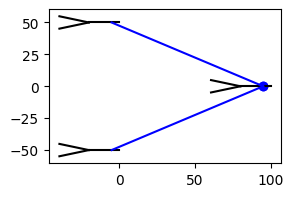

In [3]:
net.compute_xyz()
net.rotate(180)
net.arrange_in_layers(layers=[2, 1], within_layer_offset=100.0, between_layer_offset=100.0)
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = net.vis(ax=ax, detail="full")

We consider the last neuron as the output neuron and record the voltage from there:

In [4]:
net.delete_recordings()
net.cell(0).branch(0).loc(0.0).record()
net.cell(1).branch(0).loc(0.0).record()
net.cell(2).branch(0).loc(0.0).record()

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


### Defining a dataset

We will train this biophysical network on a classification task. The inputs will be values and the label is binary:

In [5]:
inputs = jnp.asarray(np.random.rand(100, 2))
labels = jnp.asarray((inputs[:, 0] + inputs[:, 1]) > 1.0)

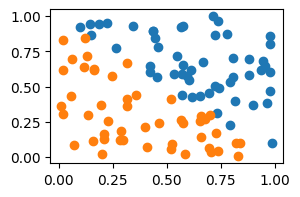

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(inputs[labels, 0], inputs[labels, 1])
_ = ax.scatter(inputs[~labels, 0], inputs[~labels, 1])

In [7]:
labels = labels.astype(float)

### Defining trainable parameters

In [8]:
net.delete_trainables()

This follows the same API as `.set()` seen in the previous tutorial. If you want to use a single parameter for all `radius`es in the entire network, do:

In [9]:
net.make_trainable("radius")

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1


We can also define parameters for individual compartments. To do this, use the `"all"` key. The following defines a separate parameter the sodium conductance for every compartment in the entire network:

In [10]:
net.cell("all").branch("all").loc("all").make_trainable("Leak_gLeak")

Number of newly added trainable parameters: 18. Total number of trainable parameters: 19


### Making synaptic parameters trainable

Synaptic parameters can be made trainable in the exact same way. To use a single parameter for all syanptic conductances in the entire network, do
```python
net.TanhRateSynapse.make_trainable("TanhRateSynapse_gS")
```

Here, we use a different syanptic conductance for all syanpses. This can be done as follows:

In [11]:
net.TanhRateSynapse.edge("all").make_trainable("TanhRateSynapse_gS")

Number of newly added trainable parameters: 2. Total number of trainable parameters: 21


### Running the simulation

Once all parameters are defined, you have to use `.get_parameters()` to obtain all trainable parameters. This is also the time to check how many trainable parameters your network has:

In [12]:
params = net.get_parameters()

You can now run the simulation with the trainable parameters by passing them to the `jx.integrate` function.

In [13]:
s = jx.integrate(net, params=params, t_max=5.0)

### Stimulating the network

The network above does not yet get any stimuli. We will use the 2D inputs from the dataset to stimulate the two input neurons. The amplitude of the step current corresponds to the input value. Below is the simulator that defines this:

In [17]:
def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=inputs / 10, delta_t=0.025, t_max=5.0)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(2).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(2).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli, delta_t=0.025)

batched_simulate = vmap(simulate, in_axes=(None, 0))

We can also inspect some traces:

In [18]:
traces = batched_simulate(params, inputs[:4])

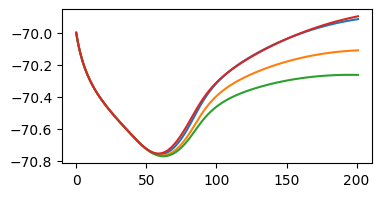

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(traces[:, 2, :].T)

### Defining a loss function

Below, we will define a loss function to be optimized. In the following cells, we will explain what is going on here.

In [20]:
def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=inputs / 10.0, delta_t=dt, t_max=t_max)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(2).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(2).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_lengths=checkpoints)

batched_simulate = vmap(simulate, in_axes=(None, 0))


def predict(params, inputs):
    traces = simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[2])  # Use the average over time of the output neuron (2) as prediction.
    return prediction + 72.0  # Such that the prediction is around 0.

batched_predict = vmap(predict, in_axes=(None, 0))


def loss(opt_params, inputs, labels):
    params = transform.forward(opt_params)

    predictions = batched_predict(params, inputs)
    losses = jnp.abs(predictions - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

jitted_grad = jit(value_and_grad(loss, argnums=0))

As you can see, we are aiming to optimize a mean absolute error loss function:
```python
def loss(opt_params, inputs, labels):
    # ...
    predictions = batched_predict(params, inputs)
    losses = jnp.abs(predictions - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.
```

### Defining parameter transformations

Before training, however, we have to enforce that all parameters are within a prespecified range (such that, e.g., conductances can not become negative). In addition, for gradient descent, all parameters should a similar scale, such that we can use the same learning rate for different parameters.

We achieve both of these things with parameter **transformations**, which we define below:

In [21]:
import jaxley.optimize.transforms as jt

In [22]:
# The structure passed to `jx.ParamTransform` should match the structure of `params`.
transform = jx.ParamTransform([
    {"radius": jt.SigmoidTransform(0.1, 5.0)},
    {"Leak_gLeak":jt.SigmoidTransform(1e-5, 1e-3)},
    {"TanhRateSynapse_gS" : jt.SigmoidTransform(1e-5, 1e-2)}
])

We then transform the parameters:

In [23]:
opt_params = transform.inverse(params)

After this transformation, each value of `opt_params` is unbounded, i.e. $\in$ [-$\infty$, $\infty$], and they all live on a similar scale.

Finally, we modify the loss function to put the parameters back to their "usual" values before they are passed on to the simulation:
```python
def loss(opt_params, inputs, labels):
    transform.forward(opt_params)
    # ...
```

### Using checkpointing

Checkpointing allows to vastly reduce the memory requirements of training biophysical models (see also [JAX's full tutorial on checkpointing](https://jax.readthedocs.io/en/latest/gradient-checkpointing.html)).

In [24]:
t_max = 5.0
dt = 0.025

levels = 2
time_points = t_max // dt + 2
checkpoints = [int(np.ceil(time_points**(1/levels))) for _ in range(levels)]

To enable checkpointing, we have to modify the `simulate` function appropriately and use
```python
def simulate(params, inputs):
    # ...
    return jx.integrate(..., checkpoint_lengths=checkpoints)
```
as is done in the code above.

### Getting the gradient

With the loss function set up, we can use `JAX`'s inbuilt functions to take the gradient through the entire ODE:

In [25]:
jitted_grad = jit(value_and_grad(loss, argnums=0))

In [26]:
value, gradient = jitted_grad(params, inputs[:4], labels[:4])

### Training

We will use the ADAM optimizer from the [optax library](https://optax.readthedocs.io/en/latest/) to optimize the free parameters (you have to install the package with `pip install optax` first):

In [27]:
import optax

In [28]:
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(opt_params)

### Writing a dataloader

Below, we just write our own (very simple) dataloader. Alternatively, you could use the dataloader from any deep learning library such as PyTorch or Tensorflow:

In [29]:
class Dataset:
    """A simple Dataloader which returns batches of the data.
    
    Instead of using this simple dataloader, you can also just use one from
    PyTorch or Tensorflow. You do not have to understand what is going on here
    to follow this tutorial.
    """

    def __init__(self, inputs: np.ndarray, labels: np.ndarray):
        """Initialize the dataloader.
        
        Args:
            inputs: Array of shape (num_samples, num_dim)
            labels: Array of shape (num_samples,)
        """
        assert len(inputs) == len(labels), "Inputs and labels must have same length"
        self.inputs = inputs
        self.labels = labels
        self.num_samples = len(inputs)
        self._rng_state = None
        self.batch_size = 1
    
    def shuffle(self, seed=None):
        """Shuffle the dataset in-place"""
        self._rng_state = np.random.get_state()[1][0] if seed is None else seed
        np.random.seed(self._rng_state)
        indices = np.random.permutation(self.num_samples)
        self.inputs = self.inputs[indices]
        self.labels = self.labels[indices]
        return self
    
    def batch(self, batch_size):
        """Create batches of the data."""
        self.batch_size = batch_size
        return self

    def __iter__(self):
        """Iterate over the dataset."""
        self.shuffle(seed=self._rng_state)
        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            yield self.inputs[start:end], self.labels[start:end]
        self._rng_state += 1

### Training loop

In [30]:
batch_size = 4
dataloader = Dataset(inputs, labels)
dataloader = dataloader.shuffle(seed=0).batch(batch_size)

for epoch in range(10):
    epoch_loss = 0.0
    
    for batch_ind, batch in enumerate(dataloader):
        current_batch, label_batch = batch
        loss_val, gradient = jitted_grad(opt_params, current_batch, label_batch)
        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)
        epoch_loss += loss_val
    
    print(f"epoch {epoch}, loss {epoch_loss}")
    
final_params = transform.forward(opt_params)

epoch 0, loss 22.65623100329529
epoch 1, loss 17.64646402672008
epoch 2, loss 11.06748391648049
epoch 3, loss 7.757597445300672
epoch 4, loss 6.991337400858107
epoch 5, loss 6.614704674020504
epoch 6, loss 6.559548399989639
epoch 7, loss 6.477586586557549
epoch 8, loss 6.427426195028944
epoch 9, loss 6.408841185659884


In [31]:
ntest = 32
predictions = batched_predict(final_params, inputs[:ntest])

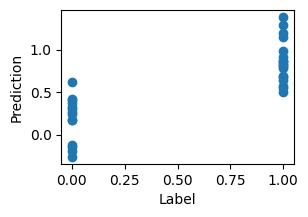

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(labels[:ntest], predictions)
_ = ax.set_xlabel("Label")
_ = ax.set_ylabel("Prediction")

Indeed, the loss goes down and the network successfully classifies the patterns.

### Summary

Puh, this was a pretty dense tutorial with a lot of material. You should have learned how to:

- compute the gradient with respect to parameters  
- use parameter transformations  
- use multi-level checkpointing  
- define optimizers  
- write dataloaders and parallelize across data  

This was the last "basic" tutorial of the `Jaxley` toolbox. If you want to learn more, check out our [Advanced Tutorials](https://jaxley.readthedocs.io/en/latest/advanced_tutorials.html). If anything is still unclear please create a [discussion](https://github.com/jaxleyverse/jaxley/discussions). If you find any bugs, please open an [issue](https://github.com/jaxleyverse/jaxley/issues). Happy coding!